In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import matplotlib.dates as mdates
from datetime import datetime

In [178]:
def ToD(df,m):
    df['{}'.format(m)]=pd.to_datetime(df['{}'.format(m)],format='%d/%m/%Y %H:%M:%S') 
    df['Month']=df['{}'.format(m)].dt.month # monthly information 
    df['CY']=df['{}'.format(m)].dt.year    # calander year information 
    df['Quarter']=df['{}'.format(m)].dt.quarter# quartely information
    df['FY']=df['{}'.format(m)].map(lambda d: d.year + 1 if d.month > 6 else d.year) # Financial year infromation
    df['Date']=df['{}'.format(m)].dt.date
    df['Time']=df['{}'.format(m)].dt.time

In [179]:
def calculate_true_range(df,n):
    df['high_low'] = df['High'] - df['Low']
    df['high_prev_close'] = abs(df['High'] - df['Close'].shift(1))
    df['low_prev_close'] = abs(df['Low'] - df['Close'].shift(1))
    df['True_Range'] = df[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)
    df['ATR']= df['True_Range'].ewm(alpha=1/n, adjust=False).mean()
    return df

In [180]:
df=pd.read_csv(r'C:\Users\ygu\Documents\ES\High Price\Input Data\All_Region_5_Min_2019_2025_18_08.csv')

In [181]:
df.columns

Index(['DateTime', 'QLD1 DISPATCH_PRICE', 'NSW1 DISPATCH_PRICE',
       'VIC1 DISPATCH_PRICE', 'SA1 DISPATCH_PRICE', 'TAS1 DISPATCH_PRICE',
       'SNOWY1 DISPATCH_PRICE'],
      dtype='object')

In [182]:
def ATR_caculation(df0, state,n,m, t1, t2):
    df0=df0[['DateTime','{} DISPATCH_PRICE'.format(state)]].copy()
    ToD(df0,'DateTime')
    df0=df0[(df0['Time'].astype(str) >= ('{}'.format(t1)))  & (df0['Time'].astype(str) <= ('{}'.format(t2)))]
   
    # Step1 Get the max and min from the dispatch in the certain period
    
    df=df0.groupby('Date').agg({'{} DISPATCH_PRICE'.format(state):['max','min']}).reset_index() 
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df.rename(columns={'{} DISPATCH_PRICE max'.format(state):'High','{} DISPATCH_PRICE min'.format(state):'Low'}, inplace=True)
   
    # Step2 Find the closing price of the time frame period
    
    df1=df0.groupby('Date').tail(1)[['Date','{} DISPATCH_PRICE'.format(state)]]
    df1.rename(columns={'{} DISPATCH_PRICE'.format(state):'Close'}, inplace=True)
    df=df.merge(df1, on='Date', how='inner')

    # Step 3 caculating the ATR
    df_new=calculate_true_range(df, n)

    # sTEP 4 Ploting the ATR 
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    #plt.plot(m_p['Date'],m_p['{}'.format('Close')] )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # axis formating 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=m))
    #plt.plot(m_p['Date'],m_p['True_Range'], label='True Range {}'.format('Morning Peak'), color='orange')
    plt.plot(df_new['Date'],df_new['ATR'], label='ATR', color='red', linestyle='--')
    #plt.plot(m_p['Date'],df['Lower Bound'], label='Lower Bound', color='green', linestyle='--')
    plt.title('ATR {}_{}-{}'.format(state, t1,t2))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    p=plt.savefig('{}'.format(state), format='png' )
    plt.close()
    #plt.show() 

    return df_new, p
    

In [192]:
import os
writer = pd.ExcelWriter(path.join(r'C:\Users\ygu\Documents\ES\High Price\Input Data', 'High Price Analysis_ATR_90_Evening.xlsx'),engine='xlsxwriter')
os.chdir(r'C:\Users\ygu\Documents\ES\High Price\Input Data')
for state in ['QLD1','NSW1','VIC1','SA1','TAS1']:
    print(state)
    df_f,p=ATR_caculation(df,state,90, 365,'17:00:00','20:30:00')
    workbook=writer.book
    worksheet=workbook.add_worksheet(state)
    writer.sheets[state] = worksheet
    df_f.to_excel(writer,sheet_name=state,startrow=0 , startcol=0,index=False,float_format="%.1f")
    worksheet.insert_image('H01' ,'{}'.format(state))
    

QLD1
NSW1
VIC1
SA1
TAS1


In [193]:
writer.close()

In [115]:
df1=df[['DateTime','QLD1 DISPATCH_PRICE']].copy()

In [116]:
ToD(df1,'DateTime')

In [117]:
df1_m_p=df1[(df1['Time'].astype(str) >= ('07:00:00'))  & (df1['Time'].astype(str) <= ('09:30:00')) ]

In [118]:
df1_af_offp=df1[(df1['Time'].astype(str) >= ('12:00:00'))  & (df1['Time'].astype(str) <= ('15:30:00'))]

In [119]:
df1_ev_p=df1[(df1['Time'].astype(str) >= ('17:00:00'))  & (df1['Time'].astype(str) <= ('21:00:00'))]

In [120]:
m_p=df1_m_p.groupby('Date').agg({'QLD1 DISPATCH_PRICE':['max','min']}).reset_index()

In [121]:
m_p.columns = [' '.join(col).strip() for col in m_p.columns.values]

In [122]:
m_p.rename(columns={'QLD1 DISPATCH_PRICE max':'High','QLD1 DISPATCH_PRICE min':'Low'}, inplace=True)

In [124]:
m_p1=df1_m_p.groupby('Date').tail(1)[['Date','QLD1 DISPATCH_PRICE']]

In [125]:
m_p1.rename(columns={'QLD1 DISPATCH_PRICE':'Close'}, inplace=True)

In [126]:
m_p1

,Date,Close
113,2019-01-01,53.73
401,2019-01-02,79.36
689,2019-01-03,80.12
977,2019-01-04,101.73
1265,2019-01-05,81.99
...,...,...
695921,2025-08-13,-12.65
696209,2025-08-14,-22.73
696497,2025-08-15,-22.73
696785,2025-08-16,-15.01


In [127]:
m_p=m_p1.merge(m_p, on='Date', how='inner')

In [131]:
calculate_true_range(m_p,90)

,Date,Close,High,Low,high_low,high_prev_close,low_prev_close,True_Range,ATR
0,2019-01-01,53.73,53.73,27.11,26.62,NaN,NaN,26.62,26.620000
1,2019-01-02,79.36,91.80,76.56,15.24,38.07,22.83,38.07,26.747222
2,2019-01-03,80.12,101.73,65.62,36.11,22.37,13.74,36.11,26.851253
3,2019-01-04,101.73,101.73,71.22,30.51,21.61,8.90,30.51,26.891906
4,2019-01-05,81.99,84.50,60.73,23.77,17.23,41.00,41.00,27.048662
...,...,...,...,...,...,...,...,...,...
2416,2025-08-13,-12.65,259.15,-13.00,272.15,271.80,0.35,272.15,176.009138
2417,2025-08-14,-22.73,175.59,-22.73,198.32,188.24,10.08,198.32,176.257036
2418,2025-08-15,-22.73,225.25,-22.73,247.98,247.98,0.00,247.98,177.053958
2419,2025-08-16,-15.01,108.75,-16.88,125.63,131.48,5.85,131.48,176.547581


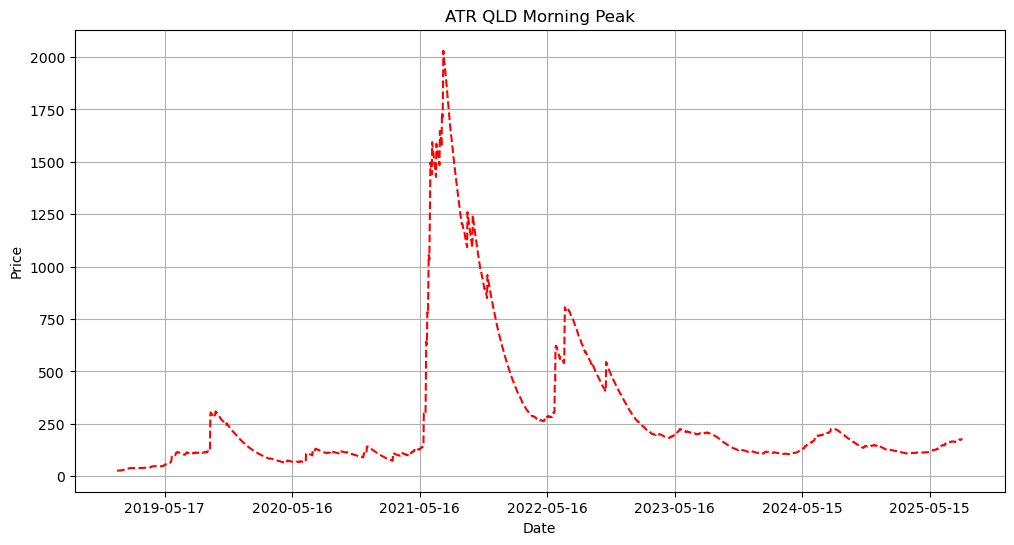

In [136]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
#plt.plot(m_p['Date'],m_p['{}'.format('Close')] )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # axis formating 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
#plt.plot(m_p['Date'],m_p['True_Range'], label='True Range {}'.format('Morning Peak'), color='orange')
plt.plot(m_p['Date'],m_p['ATR'], label='ATR', color='red', linestyle='--')
#plt.plot(m_p['Date'],df['Lower Bound'], label='Lower Bound', color='green', linestyle='--')
plt.title('ATR QLD Morning Peak')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
#plt.savefig('{}'.format(price), format='png' )
#plt.close()
plt.show()

In [18]:
def Bollinger_Bands(df,n,m,price, ticker):
    df=df[['DateTime','{}'.format(price)]].copy()
    ToD(df,m)
    df=df.groupby(['Date']).agg({'{}'.format(price):'mean'}).reset_index()
    df['Rolling_Average'] =df['{}'.format(price)].rolling(window=n).mean().reset_index(level=0, drop=True)
    df['StdDev'] = df['{}'.format(price)].rolling(window=n).std()
    num_std_dev = 2 # Typically 2 standard deviations
    df.dropna(subset='Rolling_Average', inplace=True)
    df['Upper Bound'] = df['Rolling_Average'] + (df['StdDev'] * num_std_dev)
    df['Lower Bound'] = df['Rolling_Average'] - (df['StdDev'] * num_std_dev)
    
    #df.to_csv(r'C:\Users\ygu\Documents\ES\High Price\Input Data\2019_2025_07_08_5Min_f1{}.csv'.format(price))


    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    plt.plot(df['Date'],df['{}'.format(price)] )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # axis formating 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=n))
    plt.plot(df['Date'],df['Rolling_Average'], label='Rolling_Average {} Days'.format(n), color='orange')
    plt.plot(df['Date'],df['Upper Bound'], label='Upper Bound', color='red', linestyle='--')
    plt.plot(df['Date'],df['Lower Bound'], label='Lower Bound', color='green', linestyle='--')
    plt.title(f'{ticker}{price}{n} Days Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    m=plt.savefig('{}'.format(price), format='png' )
    plt.close()
    #plt.show()

    return df, m


In [19]:
#Bollinger_Bands(df,365,'DateTime','{} DISPATCH_PRICE'.format('QLD1'),"Energy 5 Minutes Dayily Averge Price")

In [28]:
import os
writer = pd.ExcelWriter(path.join(r'C:\Users\ygu\Documents\ES\High Price\Input Data', 'High Price Analysis_365_Days.xlsx'),engine='xlsxwriter')
os.chdir(r'C:\Users\ygu\Documents\ES\High Price\Input Data')
for state in ['QLD1','NSW1','VIC1','SA1','TAS1']:
    print(state)
    df_f,p=Bollinger_Bands(df,365,'DateTime','{} DISPATCH_PRICE'.format(state),"Energy 5 Minutes Dayily Averge Price")
    workbook=writer.book
    worksheet=workbook.add_worksheet(state)
    writer.sheets[state] = worksheet
    df_f.to_excel(writer,sheet_name=state,startrow=0 , startcol=0,index=False,float_format="%.1f")
    worksheet.insert_image('H01' ,'{} DISPATCH_PRICE'.format(state))
    

QLD1
NSW1
VIC1
SA1
TAS1


In [29]:
writer.close()

In [64]:
#When someone uses two standard deviations, they mean 95% chance of the data falling within 2 standard deviations of the mean.

# Approximately 68% of the data falls within one standard deviation of the mean (± 1SD). 
#Approximately 95% of the data falls within two standard deviations of the mean (± 2SD). 
#Approximately 99.7% of the data falls within three standard deviations of the mean (± 3SD). 